In [2]:
import os, argparse, pickle, librosa
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import torch
from glob import glob
from utils import *
import models
import IPython.display as ipd

In [49]:
args = argparse.ArgumentParser()
args.add_argument('--gpus', type=str, default='0')
args.add_argument('--batch', type=int, default=1)
args.add_argument('--len', type=int, default=200)
args.add_argument('--b', type=int, default=200)
args.add_argument('--mode', type=str, default='sj_S')
args.add_argument('--model', type=str, default='FCAutoencoder')
args.add_argument('--weight', action='store_true')
args.add_argument('--ema', action='store_true')
args.add_argument('--relu', action='store_true')
args.add_argument('--feature', type=str, default='wav', choices=['wav', 'mel'])
config = args.parse_known_args(['--relu'])[0]

In [51]:
SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [52]:
ABSpath = '/home/skuser/'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'data')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = pickle.load(open(os.path.join(data_path,'stationary_accel_data.pickle'),'rb'))
sound_raw_data = pickle.load(open(os.path.join(data_path,'stationary_sound_data.pickle'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False

dataset = makeDataset(accel_raw_data, sound_raw_data, config, False)
name = f'CombineAutoencoder_sj_S_{config.len}_{config.b}_adam_0.001_decay0.7071_featurewav_weight_relu/*'
# name = 'FCAutoencoder_sj_S_40_40_adam_0.001_decay0.7071/*'
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name)), key=lambda x: float(x.split('.')[0].split('/')[-1].split('_')[-1]))[0]
model = getattr(models, name.split('_')[0])(dataset[0][0].shape[1], dataset[0][1].shape[0], dataset[0][0].shape[0], dataset[0][1].shape[1], config).to(device)

In [53]:
print(modelsavepath)
model.load_state_dict(torch.load(modelsavepath)['model'])

/home/skuser/ai_model/pytorch/test_model/model_save/CombineAutoencoder_sj_S_200_200_adam_0.001_decay0.7071_featurewav_weight_relu/10_1.1.pt


<All keys matched successfully>

In [54]:
dataset_generator = DataLoader(dataset, batch_size=64, shuffle=False)
data_res, sound_res = [], []
model.eval()
with torch.no_grad():
    for data, sound in dataset_generator:
        data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu())
        sound_res.append(sound)

In [55]:
from time import time
with torch.no_grad():
    for data, sound in dataset_generator:
        s = time()
        model(data.to(device))
        print(time() - s)
        break

0.0017435550689697266


In [56]:
data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)

In [57]:
data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))

<Figure size 432x288 with 0 Axes>

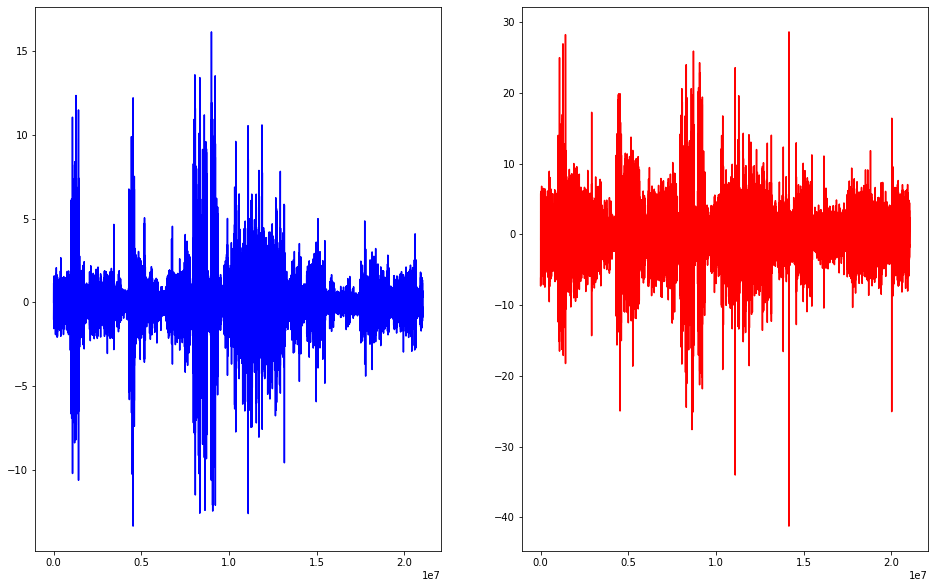

In [58]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(np.arange(data_res.size(0)), data_res[:,0], color="blue")
ax_lst[1].plot(np.arange(sound_res.size(0)), sound_res[:,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])

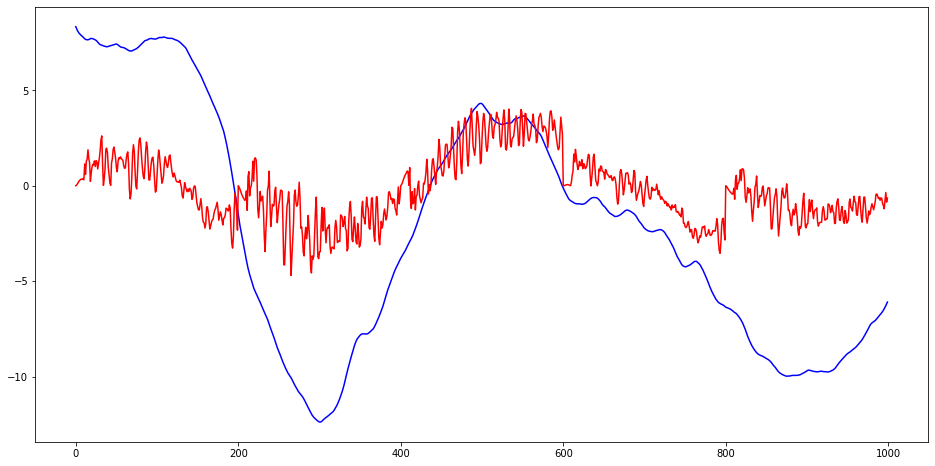

In [59]:
start = 1000000
end = 1001000
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(sound_res[start:end,0], color="blue")
ax.plot(data_res[start:end,0], color="red")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

In [60]:
# smoo = ema(data_res, n=40)

In [61]:
# fig=plt.figure(figsize=(16,8))
# ax = fig.add_subplot()
# ax.plot(smoo[start:end,1], color="red")
# ax.plot(sound_res[start:end,1], color="blue")
# plt.show(fig)

In [62]:
dBA_metric(data_res, sound_res, False)

-17.906845555539366

In [34]:
dBA_metric(smoo,sound_res,False)

-1.2066107877533838

In [40]:
write_wav(sound_res[1000000:1100000,0] - smoo[1000000:1100000,0],name='smooth')

array([0.59342414, 0.5912635 , 0.58882934, ..., 0.39009508, 0.39238495,
       0.3955417 ], dtype=float32)

In [41]:
write_wav(sound_res[1000000:1100000,0], name='sound').shape

(100000,)

In [44]:
ipd.Audio('sound.wav',normalize=False)

In [45]:
ipd.Audio('smooth.wav',normalize=False) # load a local WAV file